In [37]:
#Import functions and libraries from scripts
from GP_funcs import *
from file_opening import *
from SCB_conversion import SCB_CONVERSION

import string

#for plotting
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# import matplotlib.patheffects as pe
# for exporting things as mat for matlab
import scipy.io

# For linear regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.gaussian_process.kernels import (
    RBF, WhiteKernel, ConstantKernel, DotProduct, RationalQuadratic
)

# For kernel covariance matrix
import seaborn as sns

from sklearn.model_selection import KFold, GridSearchCV
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, Matern
import numpy as np
import math

In [2]:
'''User set values for code blocks to run '''
p = 100 #number of points wanted for GP's
colr_sc = ['#1E77B4','#FCAF38',"#BFD061"] #Color scheme
USGS_site_id = ['05325000','05325300','05330000']
markers = ['s', 'o','^', 'D']
labels = list(string.ascii_uppercase)
alpha_site_id = labels[0:len(USGS_site_id)]

plt.rcParams.update({'font.size': 12})

# create_USGS_dfs('sensor', USGS_site_id) 

# Load USGS data

In [3]:
#Load USGS data
# numbers for easy enumeration
site_numbs = np.arange(len(USGS_site_id))
# updates ADVM and grab_samples readings to included calculated SAC and SSC already and calucated dq/dt for samples
ADVM_readings = create_USGS_dfs('sensor', USGS_site_id) #Sensor readings for all sites
Grab_samples = create_USGS_dfs('samples', USGS_site_id) #Grab samples and flow for all sites
Qall_time = create_USGS_dfs('Qall', USGS_site_id) #Discharge for total time range of sensor deployment per site


dfc = pd.read_csv(r'USGS_data/USGS_site_consts.csv') # Read in constants for all sites
dfc['Site_ID'] = dfc['Site_ID'].map(toName) #Converts Site_ID to string type

data_dictionary = {} # empty dictionary to put dataframes into, keys are site id
for i, id in enumerate(USGS_site_id):
    #Selects constants for each USGS site
    Consts = dfc.loc[dfc['Site_ID'] ==  id].iloc[0, 1:]

    data_dictionary[alpha_site_id[i]] = { 'USGS_id' : id,
                            'ADVM' : ADVM_readings[id],
                            'Samples' : Grab_samples[id],
                            'Flow' : Qall_time[id],
                            'Consts' : Consts # This is a pandas series
                        }

# Run GP baseline for each site

In [ ]:
'''# run GP

def extract_kernel_hyperparams(kernel):
    params = {}
    all_params = kernel.get_params()

    for name, val in all_params.items():
        # Only keep float/numeric hyperparameters (not subkernels)
        if isinstance(val, (float, int, np.float64, np.int64)):
            params[name] = val

    return params

# Gaussian Process Regression function

def GP(SAC_m, SSC_m, p, SAC_log=False, SSC_log=False, hyperparams=-999, global_min_X=None, global_max_X=None, global_min_Y=None, global_max_Y=None):

    # Use global min/max if provided
    if global_min_X is not None and global_max_X is not None:
        min_SAC = global_min_X
        max_SAC = global_max_X
    else:
        min_SAC = SAC_m.min()
        max_SAC = SAC_m.max()
    # ---- Normalize x using min-max ----

    x_range = max_SAC - min_SAC
    if x_range < 1e-8:
        raise ValueError("Input x has too small a range to normalize reliably.")
    X = ((SAC_m - min_SAC) / x_range).reshape(-1, 1)

    # ---- Normalize y using min-max ----
    if global_min_Y is not None and global_max_Y is not None:
        min_SSC = global_min_Y
        max_SSC = global_max_Y
    else:
        min_SSC = SSC_m.min()
        max_SSC = SSC_m.max()

    y_range = max_SSC - min_SSC
    if y_range < 1e-8:
        raise ValueError("Target y has too small a range to normalize reliably.")
    y = ((SSC_m - min_SSC) / y_range).reshape(-1, 1)

    if SAC_log:
        X = np.log10(X + 1e-8)
    if SSC_log:
        y = np.log10(y + 1e-6)

    # Kernel setup
    input_mean = np.abs(np.mean(X))
    noise_std = max(np.std(y), 1e-6)

    if hyperparams == -999:
        kernel = (
            ConstantKernel(0.3, (0.05, 0.8)) *
            # RBF(length_scale=0.5, length_scale_bounds=(0.3, 2))
            Matern(length_scale=0.5, length_scale_bounds=(0.05, 2.0), nu=1.5) 
            # DotProduct(sigma_0=1.0, sigma_0_bounds=(0.1 , 2))
            # RationalQuadratic(length_scale=0.5, length_scale_bounds=(0.3, 1),
            #                  alpha=1.0, alpha_bounds=(0.1, 100.0)) 
        )
    else:
        l = hyperparams[0]
        kernel = RBF(l, length_scale_bounds="fixed")

    SAC_pred = np.linspace(0, 1, p).reshape(-1, 1)

    # Fit with cross-validated alpha
    gp = GaussianProcessRegressor(kernel=kernel, normalize_y=False)
    # since envrionmental data, trying to find best alpha (noise) but have it not be too low
    alphas = np.logspace(-2, -1, 10)
    search = GridSearchCV(gp, {'alpha': alphas}, cv=min(5, len(X)))
    search.fit(X, y.ravel())

    best_alpha = search.best_params_['alpha']
    gp_best = GaussianProcessRegressor(kernel=kernel, normalize_y=False, alpha=best_alpha)
    gp_best.fit(X, y.ravel())

    Y_pred_scaled, std_scaled = gp_best.predict(SAC_pred, return_std=True)
    val_score = mean_squared_error(y, gp_best.predict(X))

    # Invert y-scaling
    Y_pred_orig = Y_pred_scaled * y_range + min_SSC
    std_orig = std_scaled * y_range

    # Invert x-scaling for plotting
    SAC_pred_orig = SAC_pred.ravel() * x_range + min_SAC

    score = gp_best.score(X, y.ravel())
    log_marg = gp_best.log_marginal_likelihood()

    return SAC_pred_orig, Y_pred_orig, std_orig, score, log_marg, gp_best, best_alpha, (min_SAC, x_range), (min_SSC, y_range)

# ---------------- Main CV Storage Logic ------------------

model_dictionary = {}
x_key = 'SAC'
y_key = 'SSC'
p = 100  # number of prediction points

for site_id in alpha_site_id:
    site_data = data_dictionary[site_id]['Samples']
    xdata = np.array(site_data[x_key])
    ydata = np.array(site_data[y_key])

    global_min_x = xdata.min()
    global_max_x = xdata.max()
    global_min_y = ydata.min()
    global_max_y = ydata.max()

    if len(xdata) < 3:
        print(f"Skipping site {site_id}, too few samples.")
        continue

    model_dictionary[site_id] = {'folds': {}, 'num_samp': len(xdata)}

    kf = KFold(n_splits=min(5, len(xdata)), shuffle=True, random_state=0)

    for fold_idx, (train_idx, test_idx) in enumerate(kf.split(xdata)):
        x_train, y_train = xdata[train_idx], ydata[train_idx]
        x_test, y_test = xdata[test_idx], ydata[test_idx]

        try:
            SAC_pred, SSC_pred, std_pred, score, log_marg, model, alpha, x_scale, y_scale = GP(x_train, y_train, p, global_min_X=global_min_x, global_max_X=global_max_x, global_min_Y=global_min_y, global_max_Y=global_max_y)
        except Exception as e:
            print(f"Fold {fold_idx} failed for site {site_id}: {e}")
            continue

        kernel_params = extract_kernel_hyperparams(model.kernel_)
        x_min, x_range = x_scale
        x_test_scaled = (x_test - x_min) / x_range
        ypred_test_scaled, std_test_scaled = model.predict(x_test_scaled.reshape(-1, 1), return_std=True)

        y_min, y_range = y_scale
        ypred_test = ypred_test_scaled * y_range + y_min
        std_test = std_test_scaled * y_range

        rmse = math.sqrt(np.mean((y_test - ypred_test) ** 2))
        r2 = model.score(ypred_test.reshape(-1, 1), y_test.reshape(-1, 1))

        model_dictionary[site_id]['folds'][fold_idx] = {
            'x_train': x_train,
            'y_train': y_train,
            'x_test': x_test,
            'y_test': y_test,
            'n_pred': ypred_test,
            'p_pred': [SAC_pred, SSC_pred, std_pred],
            'scores': {
                'rmse': rmse,
                'r_score': r2,
                'GP_score': score,
                'GP_logmarg': log_marg,
                'alpha': alpha,
                'std': std_test,
            },
            'model': model,
            'hyperparams': kernel_params,
            'x_scaling': x_scale,
            'y_scaling': y_scale,
        }

        print(train_idx, test_idx)'''

'''
model_dictionary = {}
x_key = 'SAC'
y_key = 'SSC'

for i, site_id in enumerate(alpha_site_id):
    site_data = data_dictionary[site_id]['Samples']
    # print(site_data.keys())
    # print(site_data.keys())
    
    # Scatter plot
    xdata = np.array(site_data[x_key])
    ydata = np.array(site_data[y_key])
    print(site_id, xdata, ydata)

    SAC_pred_all, SSC_pred_all, std_all, GP_score_all, GP_logmarg_all, GP_model, n_alpha, x_scale, y_scale = GP(xdata, ydata, p)
    kernel_params = extract_kernel_hyperparams(GP_model.kernel_)
    x_min, x_range = x_scale
    x_scaled = (xdata - x_min) / x_range
    ypred_scaled, std_pred_scaled = GP_model.predict(x_scaled.reshape(-1, 1), return_std=True)
    
    y_min, y_range = y_scale
    ypred = ypred_scaled * y_range + y_min
    std_pred = std_pred_scaled * y_range

    MSE_all = np.square(np.subtract(ydata, ypred)).mean()
    rmse_all = math.sqrt(MSE_all)
    r_score_all = GP_model.score(ypred.reshape(-1, 1), ydata.reshape(-1, 1))
    print(f"Site {site_id} - RMSE: {rmse_all:.2f}, R^2: {r_score_all:.2f}, Alpha: {n_alpha}")

    model_dictionary[site_id] = {
        'hyperparams': kernel_params,
        'num_samp': len(xdata),
        'x': xdata,
        'y': ydata,
        'n_pred': ypred,
        'p_pred': [SAC_pred_all, SSC_pred_all, std_all],
        'scores': {
            'GP_score': GP_score_all,
            'GP_logmarg': GP_logmarg_all,
            'r_score': r_score_all,
            'rmse': rmse_all,
            'std': std_pred,
            'alpha': n_alpha,
        },
        'model': GP_model,
        'x_scaling': x_scale,  # (min_SAC, x_range)
        'y_scaling': y_scale,  # (min_SSC, y_range)
    }'''



/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.3. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.3. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.3. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Use

[ 0  2  3  4  5  6  7  9 10 11 12 13 14 15 16 17] [ 1  8 18 19]
[ 0  1  2  3  4  5  7  8  9 11 12 14 15 16 18 19] [ 6 10 13 17]


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.3. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.3. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/

[ 0  1  3  6  7  8  9 10 11 12 13 15 16 17 18 19] [ 2  4  5 14]
[ 0  1  2  3  4  5  6  8 10 12 13 14 15 17 18 19] [ 7  9 11 16]


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.3. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn

[ 1  2  4  5  6  7  8  9 10 11 13 14 16 17 18 19] [ 0  3 12 15]
[ 0  2  3  4  5  6  7  8  9 11 12 15 16 17 18 19 21] [ 1 10 13 14 20]


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.05. Decreasing the bound and calling fit again may find a better value.
  warnings.w

[ 0  1  2  3  4  5  7  9 10 12 13 14 15 16 17 18 20] [ 6  8 11 19 21]
[ 0  1  3  6  7  8  9 10 11 12 13 14 15 17 18 19 20 21] [ 2  4  5 16]


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.05. Decreasing the bound and calling fit again may find a better value.
  warnings.w

[ 0  1  2  3  4  5  6  8 10 11 12 13 14 15 16 19 20 21] [ 7  9 17 18]
[ 1  2  4  5  6  7  8  9 10 11 13 14 16 17 18 19 20 21] [ 0  3 12 15]


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.05. Decreasing the bound and calling fit again may find a better value.
  warnings.w

[ 0  2  3  4  5  6  7  9 10 12 14 15 16 17 18 19] [ 1  8 11 13 20]
[ 0  1  2  3  4  5  7  8  9 11 12 13 15 16 17 19 20] [ 6 10 14 18]


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.05. Decreasing the bound and calling fit again may find a better value.
  warnings.w

[ 0  1  3  6  7  8  9 10 11 12 13 14 15 16 17 18 20] [ 2  4  5 19]
[ 0  1  2  3  4  5  6  8 10 11 12 13 14 15 18 19 20] [ 7  9 16 17]
[ 1  2  4  5  6  7  8  9 10 11 13 14 16 17 18 19 20] [ 0  3 12 15]


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 0.8. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 0.8. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.05. Decreasing the bound and calling fit again may find a better value.
  warnings.war

'\nmodel_dictionary = {}\nx_key = \'SAC\'\ny_key = \'SSC\'\n\nfor i, site_id in enumerate(alpha_site_id):\n    site_data = data_dictionary[site_id][\'Samples\']\n    # print(site_data.keys())\n    # print(site_data.keys())\n    \n    # Scatter plot\n    xdata = np.array(site_data[x_key])\n    ydata = np.array(site_data[y_key])\n    print(site_id, xdata, ydata)\n\n    SAC_pred_all, SSC_pred_all, std_all, GP_score_all, GP_logmarg_all, GP_model, n_alpha, x_scale, y_scale = GP(xdata, ydata, p)\n    kernel_params = extract_kernel_hyperparams(GP_model.kernel_)\n    x_min, x_range = x_scale\n    x_scaled = (xdata - x_min) / x_range\n    ypred_scaled, std_pred_scaled = GP_model.predict(x_scaled.reshape(-1, 1), return_std=True)\n    \n    y_min, y_range = y_scale\n    ypred = ypred_scaled * y_range + y_min\n    std_pred = std_pred_scaled * y_range\n\n    MSE_all = np.square(np.subtract(ydata, ypred)).mean()\n    rmse_all = math.sqrt(MSE_all)\n    r_score_all = GP_model.score(ypred.reshape(-1, 1

In [ ]:
kf = KFold(n_splits=min(5, len(xdata)), shuffle=True, random_state=42)

KeyError: 'x'

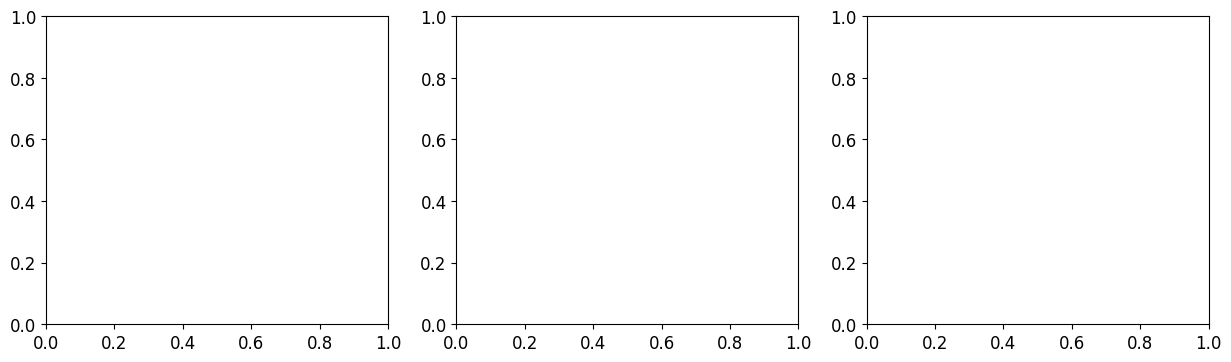

In [17]:
x_key = 'SAC'
y_key = 'SSC'

site_ids = list(model_dictionary.keys())
n_sites = len(site_ids)
n_cols = 3
n_rows = math.ceil(n_sites / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows), sharex=False, sharey=False)
axes = axes.flatten()

for i, site_id in enumerate(site_ids):
    ax = axes[i]
    model = model_dictionary[site_id]

    xdata = model['x']
    ydata = model['y']
    ypred = model['n_pred']
    SAC_pred_all, SSC_pred_all, std_all = model['p_pred']
    rmse = model['scores']['rmse']
    gp_alpha = model['scores']['alpha']

    # Sort for smooth plotting
    sorted_indices = np.argsort(xdata)
    x_sorted = xdata[sorted_indices]
    y_sorted = ypred[sorted_indices]
    std_sorted = std_all[sorted_indices] if isinstance(std_all, np.ndarray) else np.array(std_all)[sorted_indices]

    # Plot
    color = colr_sc[i % len(colr_sc)]  # wrap around if more sites than colors
    marker = markers[i % len(markers)] if 'markers' in globals() else 'o'

    ax.scatter(xdata, ydata, color=color, marker=marker, edgecolors='#2E2E2E', alpha=0.6, label='Observed')
    ax.plot(x_sorted, y_sorted, color=color, linewidth=2, label='GP fit')
    # ax.fill_between(x_sorted, y_sorted - 1.96 * std_sorted, y_sorted + 1.96 * std_sorted, alpha=0.2, color=color)
    ax.fill_between(SAC_pred_all,
                SSC_pred_all - 1.96 * std_all,
                SSC_pred_all + 1.96 * std_all,
                color=color, alpha=0.2, label='95% CI')

    try:
        kernel_str = str(model['model'].kernel_)
    except Exception as e:
        kernel_str = f"Kernel: Unknown ({e})"

    ax.set_title(
        f"Site {site_id}\nRMSE: {rmse:.2f}, gp_alpha = {gp_alpha:.2f}\n{kernel_str}",
        fontsize=10
    )

    # ax.set_title(f'Site {site_id}\nRMSE: {rmse:.2f}')
    ax.set_xlabel(x_key)
    ax.set_ylabel(y_key)
    ax.legend()

# Turn off unused subplots
for j in range(len(site_ids), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


In [45]:
print(model_dictionary['A']['folds'][0].keys())


dict_keys(['x_train', 'y_train', 'x_test', 'y_test', 'n_pred', 'p_pred', 'scores', 'model', 'hyperparams', 'x_scaling', 'y_scaling'])


In [59]:
from sklearn.metrics import mean_squared_error
import warnings
from sklearn.exceptions import UndefinedMetricWarning, ConvergenceWarning

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    warnings.filterwarnings("ignore", category=UserWarning, message="One or more of the test scores are non-finite")

def GP(
    SAC_m, SSC_m, p,
    SAC_log=False, SSC_log=False,
    hyperparams=-999,
    global_min_X=None, global_max_X=None,
    global_min_Y=None, global_max_Y=None,
    SAC_test=None, SSC_test=None,
):
    # Use global min/max if provided
    if global_min_X is not None and global_max_X is not None:
        min_SAC = global_min_X
        max_SAC = global_max_X
    else:
        min_SAC = SAC_m.min()
        max_SAC = SAC_m.max()

    x_range = max_SAC - min_SAC
    if x_range < 1e-8:
        raise ValueError("Input x has too small a range to normalize reliably.")
    X = ((SAC_m - min_SAC) / x_range).reshape(-1, 1)

    if global_min_Y is not None and global_max_Y is not None:
        min_SSC = global_min_Y
        max_SSC = global_max_Y
    else:
        min_SSC = SSC_m.min()
        max_SSC = SSC_m.max()

    y_range = max_SSC - min_SSC
    if y_range < 1e-8:
        raise ValueError("Target y has too small a range to normalize reliably.")
    y = ((SSC_m - min_SSC) / y_range).reshape(-1, 1)

    if SAC_log:
        X = np.log10(X + 1e-8)
    if SSC_log:
        y = np.log10(y + 1e-6)

    # Prepare test set if given
    if SAC_test is not None and SSC_test is not None:
        X_test = ((SAC_test - min_SAC) / x_range).reshape(-1, 1)
        y_test = ((SSC_test - min_SSC) / y_range).reshape(-1, 1)
        if SAC_log:
            X_test = np.log10(X_test + 1e-8)
        if SSC_log:
            y_test = np.log10(y_test + 1e-6)
    else:
        X_test, y_test = None, None

    best_rmse = float('inf')
    best_model = None
    best_alpha = None
    best_kernel = None
    best_kernel_params = None
    best_std = None
    best_score = None
    best_log_marg = None


    kernel = ConstantKernel(0.3, (0.05, 0.8)) * RBF(length_scale=0.5, length_scale_bounds=(0.3, 2))
    gp = GaussianProcessRegressor(kernel=kernel, normalize_y=False)
    alphas = np.logspace(-2, -1, 10)
    search = GridSearchCV(gp, {'alpha': alphas}, cv=min(5, len(X)))
    search.fit(X, y.ravel())

    best_model = search.best_estimator_
    best_alpha = search.best_params_['alpha']
    best_kernel = best_model.kernel_
    best_score = best_model.score(X, y.ravel())
    best_log_marg = best_model.log_marginal_likelihood()

    # Predict across domain and 10% farther than upper bound
    SAC_pred = np.linspace(0, 1.1, p).reshape(-1, 1)
    Y_pred_scaled, std_scaled = best_model.predict(SAC_pred, return_std=True)
    Y_pred_orig = Y_pred_scaled * y_range + min_SSC
    std_orig = std_scaled * y_range
    SAC_pred_orig = SAC_pred.ravel() * x_range + min_SAC

    return (
        SAC_pred_orig, Y_pred_orig, std_orig,
        best_score, best_log_marg,
        best_model, best_alpha,
        (min_SAC, x_range), (min_SSC, y_range)
    )


In [62]:
from sklearn.model_selection import KFold
import numpy as np
import math

model_dictionary = {}
x_key = 'SAC'
y_key = 'SSC'
p = 100  # number of prediction points

import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=UndefinedMetricWarning)
    warnings.simplefilter("ignore", category=ConvergenceWarning)
    warnings.simplefilter("ignore", category=UserWarning)
    
for site_id in alpha_site_id:
    site_data = data_dictionary[site_id]['Samples']
    xdata = np.array(site_data[x_key])
    ydata = np.array(site_data[y_key])

    global_min_x = xdata.min()
    global_max_x = xdata.max()
    global_min_y = ydata.min()
    global_max_y = ydata.max()

    if len(xdata) < 3:
        print(f"Skipping site {site_id}, too few samples.")
        continue

    model_dictionary[site_id] = {'folds': {}, 'num_samp': len(xdata)}

    kf = KFold(n_splits=min(5, len(xdata)), shuffle=True, random_state=0)

    for fold_idx, (train_idx, test_idx) in enumerate(kf.split(xdata)):
        x_train, y_train = xdata[train_idx], ydata[train_idx]
        x_test, y_test = xdata[test_idx], ydata[test_idx]

        try:
            SAC_pred, SSC_pred, std_pred, score, log_marg, model, alpha, x_scale, y_scale = GP(
                x_train, y_train, p,
                SAC_test=x_test, SSC_test=y_test,
                global_min_X=global_min_x, global_max_X=global_max_x,
                global_min_Y=global_min_y, global_max_Y=global_max_y,
            )
        except Exception as e:
            print(f"Fold {fold_idx} failed for site {site_id}: {e}")
            continue

        kernel_params = extract_kernel_hyperparams(model.kernel_)

        x_min, x_range = x_scale
        x_test_scaled = (x_test - x_min) / x_range
        ypred_test_scaled, std_test_scaled = model.predict(x_test_scaled.reshape(-1, 1), return_std=True)

        y_min, y_range = y_scale
        ypred_test = ypred_test_scaled * y_range + y_min
        std_test = std_test_scaled * y_range

        rmse = math.sqrt(np.mean((y_test - ypred_test) ** 2))
        r2 = model.score(x_test_scaled.reshape(-1, 1), (y_test - y_min) / y_range)

        model_dictionary[site_id]['folds'][fold_idx] = {
            'x_train': x_train,
            'y_train': y_train,
            'x_test': x_test,
            'y_test': y_test,
            'n_pred': ypred_test,
            'p_pred': [SAC_pred, SSC_pred, std_pred],
            'scores': {
                'rmse': rmse,
                'r_score': r2,
                'GP_score': score,
                'GP_logmarg': log_marg,
                'alpha': alpha,
                'std': std_test,
            },
            'model': model,
            'hyperparams': kernel_params,
            'x_scaling': x_scale,
            'y_scaling': y_scale,
        }

        print(f"Site {site_id} | Fold {fold_idx} | RMSE: {rmse:.2f} | R^2: {r2:.2f}")

#save median gp_score fold as baseline model

for site_id in model_dictionary:
    fold_data = model_dictionary[site_id].get('folds', {})

    if not fold_data:
        continue  # Skip if no folds available

    # Extract GP scores from all folds
    fold_scores = [(fold_idx, fold['scores']['GP_score']) for fold_idx, fold in fold_data.items()]
    sorted_scores = sorted(fold_scores, key=lambda x: x[1])  # Sort by GP_score

    # Find the median score and corresponding fold
    mid = len(sorted_scores) // 2
    median_fold_idx = sorted_scores[mid][0]  # Use floor of mid (can also average if even count)

    # Save that fold's data as baseline
    model_dictionary[site_id]['baseline'] = {
        'fold_idx': median_fold_idx,
        **fold_data[median_fold_idx]
    }

    print(f"Site {site_id} baseline set to fold {median_fold_idx} with GP_score = {sorted_scores[mid][1]:.3f}")



/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.3. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.3. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.3. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Use

Site A | Fold 0 | RMSE: 304.80 | R^2: -0.07
Site A | Fold 1 | RMSE: 329.79 | R^2: 0.19


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.3. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.3. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/

Site A | Fold 2 | RMSE: 151.95 | R^2: -2.20
Site A | Fold 3 | RMSE: 364.16 | R^2: -0.05


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.3. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn

Site A | Fold 4 | RMSE: 134.74 | R^2: -0.82
Site B | Fold 0 | RMSE: 550.15 | R^2: 0.08


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.05. Decreasing the bound and calling fit again may find a better value.
  warnings.w

Site B | Fold 1 | RMSE: 205.21 | R^2: 0.42
Site B | Fold 2 | RMSE: 54.00 | R^2: 0.61


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.05. Decreasing the bound and calling fit again may find a better value.
  warnings.w

Site B | Fold 3 | RMSE: 118.96 | R^2: -0.20
Site B | Fold 4 | RMSE: 103.55 | R^2: -7.80


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.05. Decreasing the bound and calling fit again may find a better value.
  warnings.w

Site C | Fold 0 | RMSE: 141.63 | R^2: 0.15
Site C | Fold 1 | RMSE: 115.88 | R^2: 0.25


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.05. Decreasing the bound and calling fit again may find a better value.
  warnings.w

Site C | Fold 2 | RMSE: 581.24 | R^2: -0.71
Site C | Fold 3 | RMSE: 91.76 | R^2: 0.83


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.3. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn

Site C | Fold 4 | RMSE: 111.33 | R^2: -0.63
Site A baseline set to fold 4 with GP_score = 0.519
Site B baseline set to fold 4 with GP_score = 0.912
Site C baseline set to fold 4 with GP_score = 0.769


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


In [70]:
print(model_dictionary['A']['baseline']['hyperparams'])

{'k1__constant_value': 0.24558110891167173, 'k2__length_scale': 0.9295008620844819}


Site  Fold  RMSE  GP_score  GP_logmarg  Alpha                             Kernel
   A     0 305.0  0.806960   -0.296729   0.01   0.525**2 * RBF(length_scale=0.3)
   A     1 330.0  0.414542   -1.942668   0.10  0.37**2 * RBF(length_scale=0.971)
   A     2 152.0  0.537507   -3.052654   0.10 0.508**2 * RBF(length_scale=0.906)
   A     3 364.0  0.392586   -1.849295   0.10 0.297**2 * RBF(length_scale=0.663)
   A     4 135.0  0.518723   -3.148610   0.10  0.496**2 * RBF(length_scale=0.93)
   B     0 550.0  0.264522    1.068794   0.10 0.224**2 * RBF(length_scale=0.826)
   B     1 205.0  0.979471   12.974842   0.01 0.592**2 * RBF(length_scale=0.404)
   B     2  54.0  0.905049   11.013399   0.01 0.685**2 * RBF(length_scale=0.545)
   B     3 119.0  0.912931   11.717526   0.01 0.747**2 * RBF(length_scale=0.648)
   B     4 104.0  0.911907   11.493353   0.01  0.75**2 * RBF(length_scale=0.637)
   C     0 142.0  0.911290   10.992834   0.01  0.859**2 * RBF(length_scale=1.14)
   C     1 116.0  0.833267  

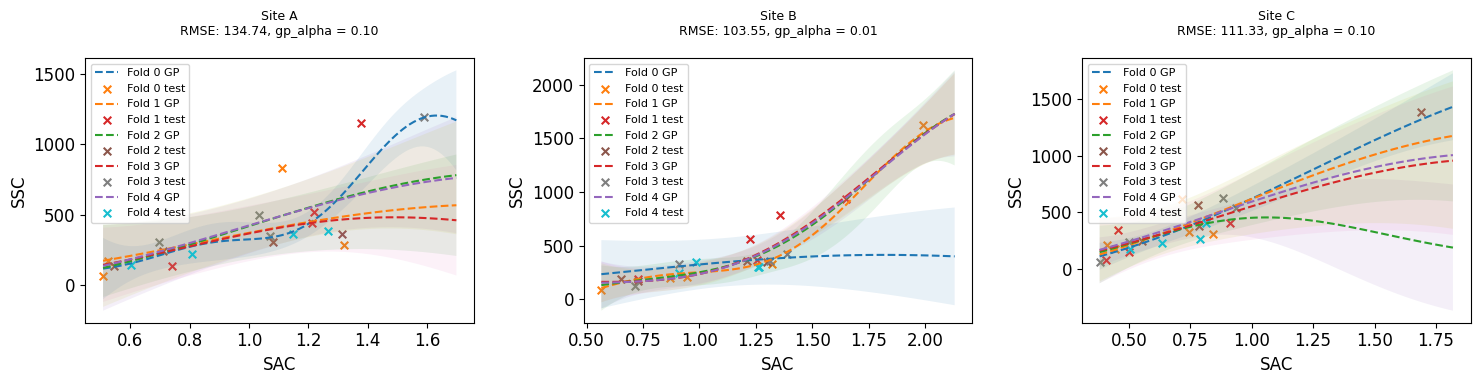

In [79]:
x_key = 'SAC'
y_key = 'SSC'
from collections import defaultdict

site_ids = list(model_dictionary.keys())
n_sites = len(site_ids)
n_cols = 3
n_rows = math.ceil(n_sites / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows), sharex=False, sharey=False)
axes = axes.flatten()

# Collect metrics into a list of dicts
summary_rows = []

for i, site_id in enumerate(site_ids):
    ax = axes[i]
    model = model_dictionary[site_id]

    # xdata = model['x']
    # ydata = model['y']
    # ypred = model['n_pred']
    # SAC_pred_all, SSC_pred_all, std_all = model['p_pred']
    # rmse = model['scores']['rmse']
    # gp_alpha = model['scores']['alpha']

    # # Sort for smooth plotting
    # sorted_indices = np.argsort(xdata)
    # x_sorted = xdata[sorted_indices]
    # y_sorted = ypred[sorted_indices]
    # std_sorted = std_all[sorted_indices] if isinstance(std_all, np.ndarray) else np.array(std_all)[sorted_indices]

    # color = colr_sc[i % len(colr_sc)]
    # marker = markers[i % len(markers)] if 'markers' in globals() else 'o'

    # ax.scatter(xdata, ydata, color=color, marker=marker, edgecolors='#2E2E2E', alpha=0.5, label='Observed')
    # ax.plot(x_sorted, y_sorted, color=color, linewidth=2, label='Full GP fit')
    # ax.fill_between(
    #     SAC_pred_all,
    #     SSC_pred_all - 1.96 * std_all,
    #     SSC_pred_all + 1.96 * std_all,
    #     color=color, alpha=0.15, label='Full 95% CI'
    # )

    # Plot each fold’s test prediction
    folds = model.get("folds", {})
    for fold_id, fold_data in folds.items():
        try:
            kernel_str = str(fold_data['model'].kernel_)
        except Exception as e:
            kernel_str = f"Kernel: Unknown ({e})"   
            
        test_x = fold_data['x_test']
        test_y = fold_data['y_test']
        ypred = fold_data['n_pred']
        SAC_pred_all, SSC_pred_all, std_pred_all = fold_data['p_pred']
        std_pred = fold_data['scores']['std']
        gp_alpha = fold_data['scores']['alpha']
        rmse = fold_data['scores']['rmse']
        summary_rows.append({
            "Site": site_id,
            "Fold": fold_id,
            "RMSE": round(rmse, 0),
            "GP_score": fold_data['scores']['GP_score'],
            "GP_logmarg": fold_data['scores']['GP_logmarg'],
            "Alpha": round(gp_alpha, 2),
            "Kernel": kernel_str
        })

       

        sorted_idx = np.argsort(test_x)
        test_x_sorted = test_x[sorted_idx]
        ypred_sorted = ypred[sorted_idx]
        std_sorted = std_pred[sorted_idx]


    #    ''' 
    #    ax.plot(test_x_sorted, ypred_sorted, linestyle='--', linewidth=1.5, label=f'Fold {fold_id} GP')
    #     ax.fill_between(
    #         test_x_sorted,
    #         ypred_sorted - 1.96 * std_sorted,
    #         ypred_sorted + 1.96 * std_sorted,
    #         alpha=0.1
    #     )
    #     '''
        ax.plot(SAC_pred_all, SSC_pred_all, linestyle='--', linewidth=1.5, label=f'Fold {fold_id} GP')
        ax.fill_between(
            SAC_pred_all,
            SSC_pred_all - 1.96 * std_pred_all,
            SSC_pred_all + 1.96 * std_pred_all,
            alpha=0.1
        )
        ax.scatter(test_x, test_y, marker='x', s=30, label=f'Fold {fold_id} test')

  

    ax.set_title(
        f"Site {site_id}\nRMSE: {rmse:.2f}, gp_alpha = {gp_alpha:.2f}\n",
        fontsize=9
    )
    ax.set_xlabel(x_key)
    ax.set_ylabel(y_key)

    # Remove duplicate labels
    handles, labels = ax.get_legend_handles_labels()
    unique_labels = dict(zip(labels, handles))
    ax.legend(unique_labels.values(), unique_labels.keys(), fontsize=8)

# Turn off unused subplots
for j in range(len(site_ids), len(axes)):
    axes[j].axis('off')

# Convert to DataFrame and print
summary_df = pd.DataFrame(summary_rows)
print(summary_df.to_string(index=False))

plt.tight_layout()
plt.show()


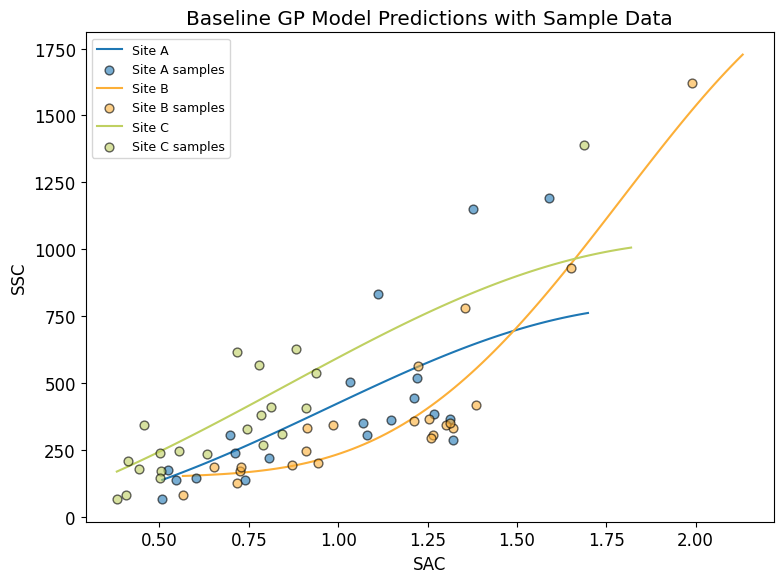


Baseline Model Summary:
Site   RMSE  GP_score  GP_logmarg  Alpha                             Kernel
   A 134.74     0.519        -3.1   0.10  0.496**2 * RBF(length_scale=0.93)
   B 103.55     0.912        11.5   0.01  0.75**2 * RBF(length_scale=0.637)
   C 111.33     0.769        -0.8   0.10 0.565**2 * RBF(length_scale=0.929)


In [81]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

x_key = 'SAC'
y_key = 'SSC'

fig, ax = plt.subplots(figsize=(8, 6))

baseline_rows = []

for i, site_id in enumerate(model_dictionary.keys()):
    model = model_dictionary[site_id]
    baseline_info = model.get('baseline')
    site_data = data_dictionary[site_id]['Samples']
    xdata = np.array(site_data[x_key])
    ydata = np.array(site_data[y_key])

    if baseline_info is None:
        print(f"No baseline model for site {site_id}")
        continue

    SAC_pred_all, SSC_pred_all, std_pred_all = baseline_info['p_pred']
    rmse = baseline_info['scores']['rmse']
    gp_score = baseline_info['scores']['GP_score']
    gp_logmarg = baseline_info['scores']['GP_logmarg']
    gp_alpha = baseline_info['scores']['alpha']
    kernel_str = str(baseline_info['model'].kernel_)

    # Plot model prediction and CI
    ax.plot(SAC_pred_all, SSC_pred_all, color=colr_sc[i], label=f"Site {site_id}", zorder=1)
    # ax.fill_between(
    #     SAC_pred_all,
    #     SSC_pred_all - 1.96 * std_pred_all,
    #     SSC_pred_all + 1.96 * std_pred_all,
    #     color=colr_sc[i],
    #     alpha=0.2,
    #     zorder=0,
    # )

    # Plot observed samples
    ax.scatter(xdata, ydata, color=colr_sc[i], marker='o', edgecolor='k', s=40, alpha=0.6, label=f"Site {site_id} samples", zorder=2)

    # Save summary info
    baseline_rows.append({
        "Site": site_id,
        "RMSE": round(rmse, 2),
        "GP_score": round(gp_score, 3),
        "GP_logmarg": round(gp_logmarg, 1),
        "Alpha": round(gp_alpha, 3),
        "Kernel": kernel_str
    })

# Plot formatting
ax.set_title("Baseline GP Model Predictions with Sample Data")
ax.set_xlabel(x_key)
ax.set_ylabel(y_key)

# Deduplicate legend
handles, labels = ax.get_legend_handles_labels()
unique = dict(zip(labels, handles))
ax.legend(unique.values(), unique.keys(), fontsize=9)

plt.tight_layout()
plt.show()

# Print summary table
summary_df = pd.DataFrame(baseline_rows)
print("\nBaseline Model Summary:")
print(summary_df.to_string(index=False))


In [84]:
print(model_dictionary['A']['baseline'].keys())

dict_keys(['fold_idx', 'x_train', 'y_train', 'x_test', 'y_test', 'n_pred', 'p_pred', 'scores', 'model', 'hyperparams', 'x_scaling', 'y_scaling'])


## Compute correlation matricies

In [89]:
def const_rbf_kernel(x, y, length_scale, const):
    rbf = math.exp(- math.dist([x],[y]) / (2*length_scale**2) )
    return const * rbf

def cov_to_cor(cov):
    d = np.sqrt(np.diag(cov))
    return cov / np.outer(d, d)

correlation_matrices = {}
n_range = [10, 25, 50]

for id in alpha_site_id:
    correlation_matrices[id] = {}
    
    if 'baseline' not in model_dictionary[id]:
        print(f"Skipping site {id}, no baseline model found.")
        continue

    mod = model_dictionary[id]['baseline']
    x = np.array(mod['x_train'])
    y = np.array(mod['y_train'])
    # pred_x = np.array(mod['p_pred'][0])
    # pred_y = np.array(mod['p_pred'][1])

    # Hyperparameters 
    hp = mod['hyperparams']
    const = hp.get('k1__constant_value', None)
    l = hp.get('k2__length_scale', None)

    if l is None or const is None:
        raise ValueError(f"Missing hyperparameters in site {id}")

    # Sort input data
    ord = np.argsort(x)
    x_sort = x[ord]
    y_sort = y[ord]

    x_min = np.min(x_sort)
    x_max = np.max(x_sort)
    x_sort_scaled = (x_sort - x_min) / (x_max - x_min)

    # --- Variable number of prediction points using this site's kernel ---
    correlation_matrices[id]['n'] = {}
    for n in n_range:
        nx_trend_scaled = np.linspace(0, 1, n)
        kern = np.zeros((n, n))
        for i in range(n):
            for j in range(n):
                kern[i, j] = const_rbf_kernel(nx_trend_scaled[i], nx_trend_scaled[j], l, const)
        cor_mat = cov_to_cor(kern)

        correlation_matrices[id]['n'][n] = {
            'hyperparams': {
                'length_scale': l,
                'constant_value': const,
            },
            'cor_matrix': cor_mat,
            'range': nx_trend_scaled * (x_max - x_min) + x_min,
            'range_scaled': nx_trend_scaled,
        }

    # --- Evaluate all other sites' kernels on this site's inputs ---
    correlation_matrices[id]['num_samp'] = {}
    for model_id in alpha_site_id:
        if 'baseline' not in model_dictionary[model_id]:
            print(f"Skipping model from {model_id}, no baseline.")
            continue

        hp_mod = model_dictionary[model_id]['baseline']['hyperparams']
        const_mod = hp_mod.get('k1__constant_value', None)
        l_mod = hp_mod.get('k2__length_scale', None)

        if const_mod is None or l_mod is None:
            continue

        samp_n = len(x_sort_scaled)
        kern = np.zeros((samp_n, samp_n))
        for i in range(samp_n):
            for j in range(samp_n):
                kern[i, j] = const_rbf_kernel(x_sort_scaled[i], x_sort_scaled[j], l_mod, const_mod)
        cor_mat = cov_to_cor(kern)

        correlation_matrices[id]['num_samp'][model_id] = {
            'hyperparams': {
                'length_scale': l_mod,
                'constant_value': const_mod,
            },
            'cor_matrix': cor_mat,
            'range': x_sort,
            'range_scaled': x_sort_scaled,
            'n': samp_n,
        }

        print(f"→ Site {id} using model {model_id}: corr shape {cor_mat.shape}")



→ Site A using model A: corr shape (16, 16)
→ Site A using model B: corr shape (16, 16)
→ Site A using model C: corr shape (16, 16)
→ Site B using model A: corr shape (18, 18)
→ Site B using model B: corr shape (18, 18)
→ Site B using model C: corr shape (18, 18)
→ Site C using model A: corr shape (17, 17)
→ Site C using model B: corr shape (17, 17)
→ Site C using model C: corr shape (17, 17)


In [90]:
print(kern.shape, cor_mat.shape)

print(cor_mat)

(17, 17) (17, 17)
[[1.         0.9885202  0.98635209 0.97234823 0.96737446 0.94846131
  0.94833045 0.9257274  0.86154092 0.85133748 0.8381165  0.83622167
  0.81507867 0.80101426 0.7910403  0.78171313 0.56044239]
 [0.9885202  1.         0.99780672 0.98364023 0.9786087  0.95947591
  0.95934353 0.93647798 0.8715461  0.86122416 0.84784965 0.84593281
  0.82454428 0.81031654 0.80022674 0.79079126 0.56695088]
 [0.98635209 0.99780672 1.         0.98580237 0.98075979 0.96158494
  0.96145227 0.93853646 0.87346185 0.86311723 0.84971331 0.84779226
  0.82635672 0.8120977  0.80198572 0.7925295  0.5681971 ]
 [0.97234823 0.98364023 0.98580237 1.         0.99488479 0.97543379
  0.97529921 0.95205336 0.88604154 0.87554793 0.86195097 0.86000226
  0.83825799 0.82379361 0.81353601 0.80394359 0.57638033]
 [0.96737446 0.9786087  0.98075979 0.99488479 1.         0.98044899
  0.98031371 0.95694835 0.89059713 0.88004957 0.8663827  0.86442396
  0.8425679  0.82802915 0.81771881 0.80807707 0.5793438 ]
 [0.94846131

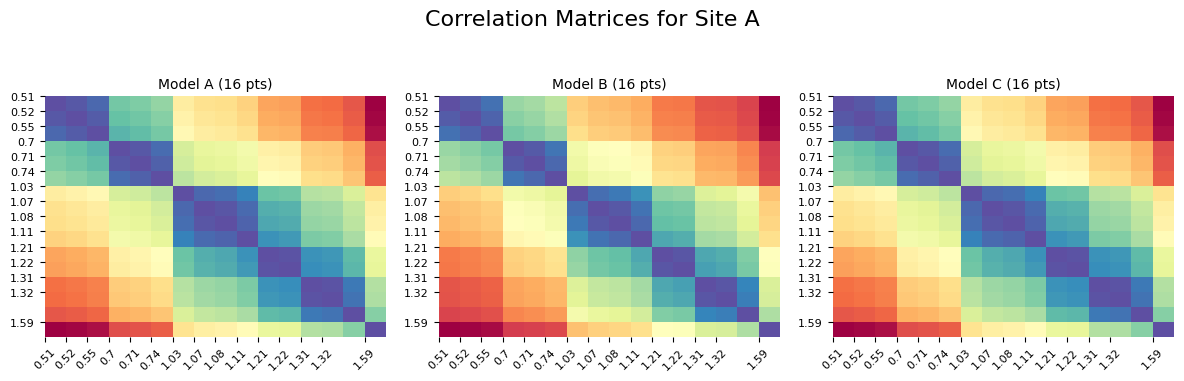

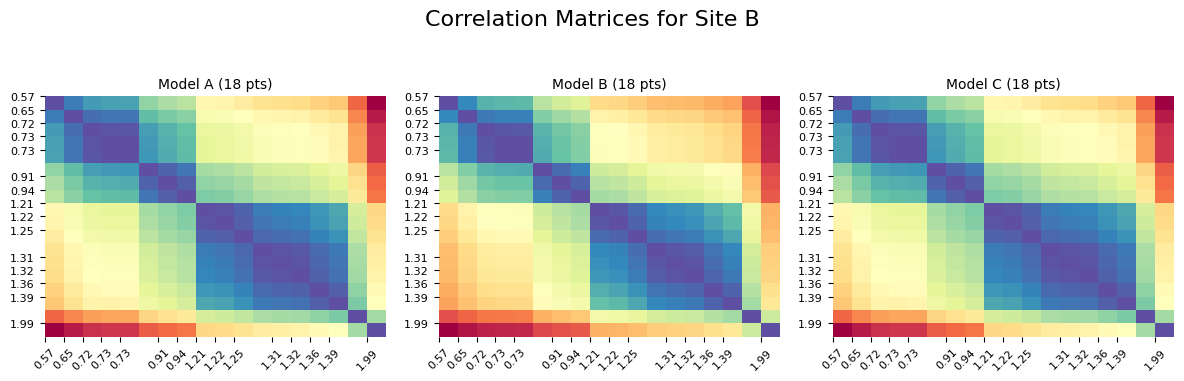

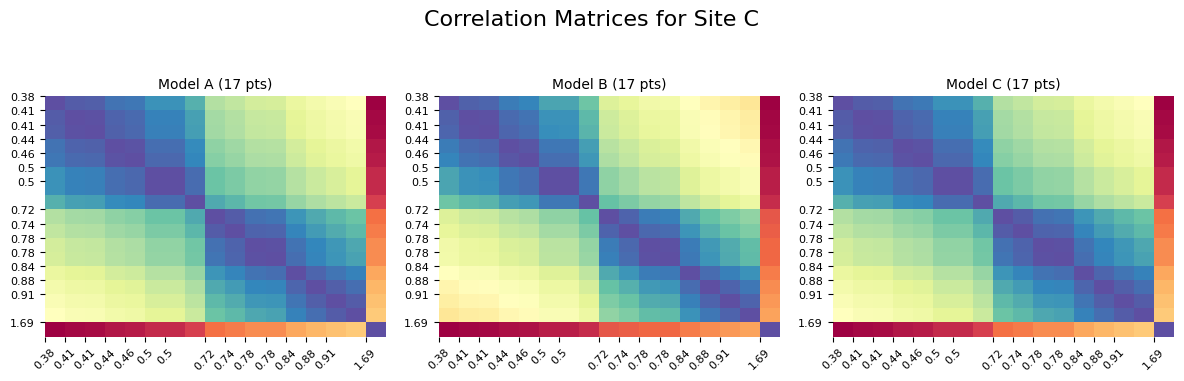

In [91]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

for id, models in correlation_matrices.items():
    num_models = len(models['num_samp'])
    num_plots = num_models
    nrows, ncols = 1, num_models  # Adjusted to fit all models in one row

    fig, axes = plt.subplots(nrows, ncols, figsize=(4* n_cols, 4* n_rows))
    axes = axes.flatten()

    for index, (model_id, data) in enumerate(models['num_samp'].items()):
        if index >= len(axes):
            break

        cor_mat = data['cor_matrix']
        nx_trend = data['range']
        n_points = len(nx_trend)

        # Decide whether to annotate or use tick labels based on matrix size
        show_ticks = n_points <= 20
        xticks = np.round(np.sort(nx_trend), 2) if show_ticks else False
        yticks = np.round(np.sort(nx_trend), 2) if show_ticks else False
        nx_trend_sorted = np.sort(nx_trend)  # make sure x is sorted

        # Decide how many ticks to show (15 or fewer)
        n_total = len(nx_trend_sorted)
        n_ticks = min(15, n_total)

        # Get tick indices evenly spaced by index
        tick_indices = np.linspace(0, n_total - 1, n_ticks, dtype=int)
        tick_labels = np.round(nx_trend_sorted[tick_indices], 2)

        sns.heatmap(
            cor_mat,
            cbar=False,
            annot=False,  # turn on if n_points is small and needed
            cmap="Spectral",
            fmt='.2f',
            ax=axes[index],
            xticklabels=False,
            yticklabels=False
        )
        axes[index].set_title(f'Model {model_id} ({n_points} pts)', fontsize=10)
        # Set manual ticks and labels
        axes[index].set_xticks(tick_indices)
        axes[index].set_xticklabels(tick_labels, rotation=45, fontsize=8) 


        axes[index].set_yticks(tick_indices)
        axes[index].set_yticklabels(tick_labels, fontsize=8)

    # Hide any unused axes
    for j in range(index + 1, len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle(f'Correlation Matrices for Site {id}', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    # Optional: save to file
    # plt.savefig(f'correlation_matrices_site_{id}.png', dpi=150)
    plt.close()


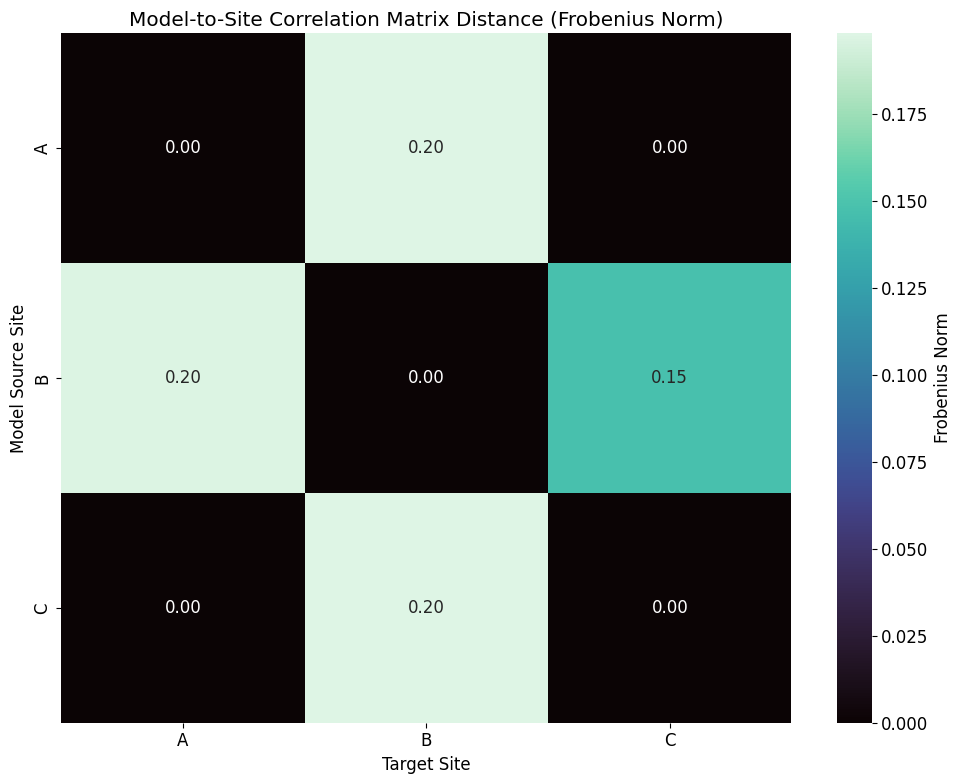

In [92]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

site_ids = list(correlation_matrices.keys())
n_sites = len(site_ids)

# Frobenius distance matrix (models vs sites)
fro_rel_matrix = np.zeros((n_sites, n_sites))

for i, model_site in enumerate(site_ids):
    for j, target_site in enumerate(site_ids):
        try:
            # Model from model_site, applied to target_site
            A = correlation_matrices[target_site]['num_samp'][model_site]['cor_matrix']

            # Reference matrix: model trained & applied on target_site itself
            B = correlation_matrices[target_site]['num_samp'][target_site]['cor_matrix']
            n = B.shape[0]

            # Option 1: normalized by sqrt(n)
            norm_diff = np.linalg.norm(A - B, 'fro') / np.sqrt(n)

            # Option 2: relative to reference matrix norm
            ref_norm = np.linalg.norm(B, 'fro')
            rel_diff = np.linalg.norm(A - B, 'fro') / ref_norm if ref_norm != 0 else np.nan

            fro_rel_matrix[i, j] = rel_diff  # use rel_diff or norm_diff

        except KeyError:
            continue  # Leave as NaN if matrix doesn't exist

plt.figure(figsize=(10, 8))
sns.heatmap(fro_rel_matrix, annot=True, fmt=".2f", cmap="mako", 
            xticklabels=site_ids, yticklabels=site_ids, cbar_kws={'label': 'Frobenius Norm'})

plt.xlabel("Target Site")
plt.ylabel("Model Source Site")
plt.title("Model-to-Site Correlation Matrix Distance (Frobenius Norm)")
plt.tight_layout()
plt.show()



# Matlab OMP calculation

## Save correlation mat for matlab

In [94]:
MATLAB_FILEPATH = "GVR_USGS"
MATLAB_FILEPATH_ALLSAMP = MATLAB_FILEPATH + "/all_samp"
MATLAB_FILEPATH_ALLSAMP_N = MATLAB_FILEPATH_ALLSAMP + "/n_point"   
# do this to get the cor matrix
for id, models in correlation_matrices.items():
    print(f"data set: ")
    
    
    for model_id, data in models['num_samp'].items():
        # print("model_id:" , model_id)
        cor_mat = data['cor_matrix']
        nx_trend = data['range_scaled']
        
        scipy.io.savemat(f'{MATLAB_FILEPATH_ALLSAMP}/corr_samp{id}{model_id}.mat', {'cor_mat': cor_mat})
    scipy.io.savemat(f'{MATLAB_FILEPATH_ALLSAMP}/xdata_scaled_samp{id}.mat', {'xdata': nx_trend})
    
    
    
    # save n samples too
    for n, data in models['n'].items():
        # print("num_points:" , n)
        cor_mat = data['cor_matrix']
        nx_trend = data['range_scaled']
        
        scipy.io.savemat(f'{MATLAB_FILEPATH_ALLSAMP_N}/xdata_scaled_range{id}{n}.mat', {'xdata': nx_trend})
        scipy.io.savemat(f'{MATLAB_FILEPATH_ALLSAMP_N}/corr_range{id}{n}.mat', {'cor_mat': cor_mat})
        


data set: 
data set: 
data set: 


## Read OMP selection from Matlab

In [95]:
""" read sample selection and scores given arbritrary SAC range """
range_selection = {}

for id in alpha_site_id:
    range_selection[id] = {}
    for n in n_range:
        range_selection[id][n] = {}
        mat_dict = range_selection[id][n]
        mat_file = scipy.io.loadmat(f'{MATLAB_FILEPATH_ALLSAMP_N}/range{id}{n}.mat')
        mat_dict['samples'] = mat_file['A'][0]-1 # for matlab to python indexing
        mat_dict['score'] = mat_file['scores'][0]

""" read in sample selection out of grab samples we already have (permutating through each correlation matrix that was used to select samples) """
grabSamp_selection = {}

# selects site with grab samples used
for id in alpha_site_id:
    grabSamp_selection[id] = {}
    # cycle through kernel used
    for model_id in alpha_site_id:
        grabSamp_selection[id][model_id] = {}
        mat_dict = grabSamp_selection[id][model_id] 
        mat_file = scipy.io.loadmat(f'{MATLAB_FILEPATH_ALLSAMP}/samp{id}{model_id}.mat')
        mat_dict['samples'] = mat_file['A'][0]-1 # for matlab to python indexing
        mat_dict['score'] = mat_file['scores'][0]


## Plot Elbow Curve

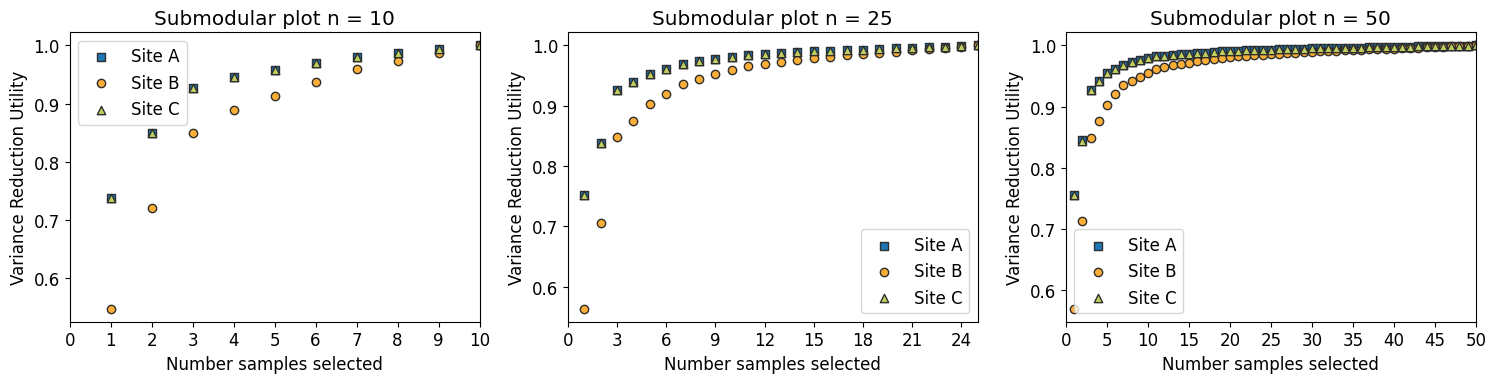

In [96]:
# Plotting the curves with subplots for each item in n_range
n_sites = len(site_ids)
n_cols = 4
n_rows = math.ceil(n_sites / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5* n_cols, 4 * n_rows))
axes = axes.flatten()

for idx, n in enumerate(n_range):
    if idx >= len(axes):
        break  # In case n_range has more than 4 items

    ax = axes[idx]
    for i, id in enumerate(alpha_site_id):
        dict_data = range_selection[id][n]
        samples = dict_data['samples']
        scores = dict_data['score']
        
        # Create a consistent x-axis since the samples is sample number, but we care about number of samples selected
        x_axis = range(1, len(samples) + 1)
        
        # Plot the curve, preserving the relationship between samples and scores
        ax.scatter(x_axis, scores, color=colr_sc[i], marker=markers[i], edgecolors='#2E2E2E', label=f'Site {id}')

    
    ax.set_xlabel('Number samples selected')
    ax.set_ylabel('Variance Reduction Utility')
    ax.set_title(f'Submodular plot n = {n}')
    ax.legend()

    # Force x-axis to have integer ticks
    ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    ax.set_xlim(0, len(samples))

# Hide any unused subplots if n_range has less than 4 items
for i in range(len(n_range), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

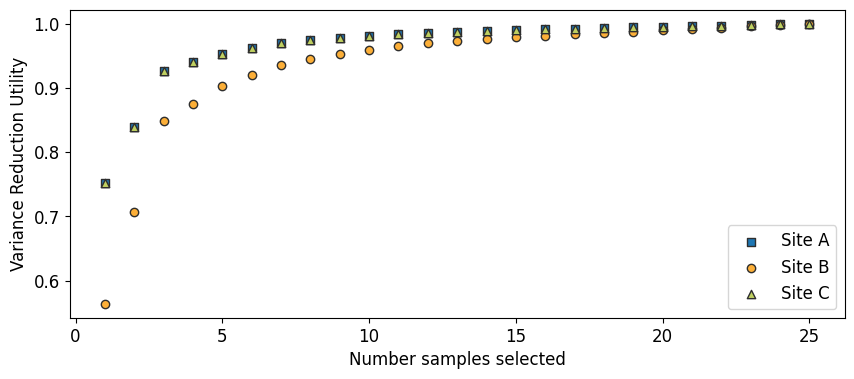

In [97]:
# plot only for n = 25

fig, ax = plt.subplots(figsize=(10, 4))

for i, id in enumerate(alpha_site_id):
    dict_data = range_selection[id][25]
    samples = dict_data['samples']
    scores = dict_data['score']
    
    # Create a consistent x-axis since the samples is sample number, but we care about number of samples selected
    x_axis = range(1, len(samples) + 1)
    
    # Plot the curve, preserving the relationship between samples and scores
    ax.scatter(x_axis, scores, color=colr_sc[i], marker=markers[i], edgecolors='#2E2E2E', label=f'Site {id}')


ax.set_xlabel('Number samples selected')
ax.set_ylabel('Variance Reduction Utility')
ax.legend()
# plt.savefig('figures/submod_n25.png', dpi=500)

## Elbows with actual field samples

A C plotted
B C plotted
C C plotted


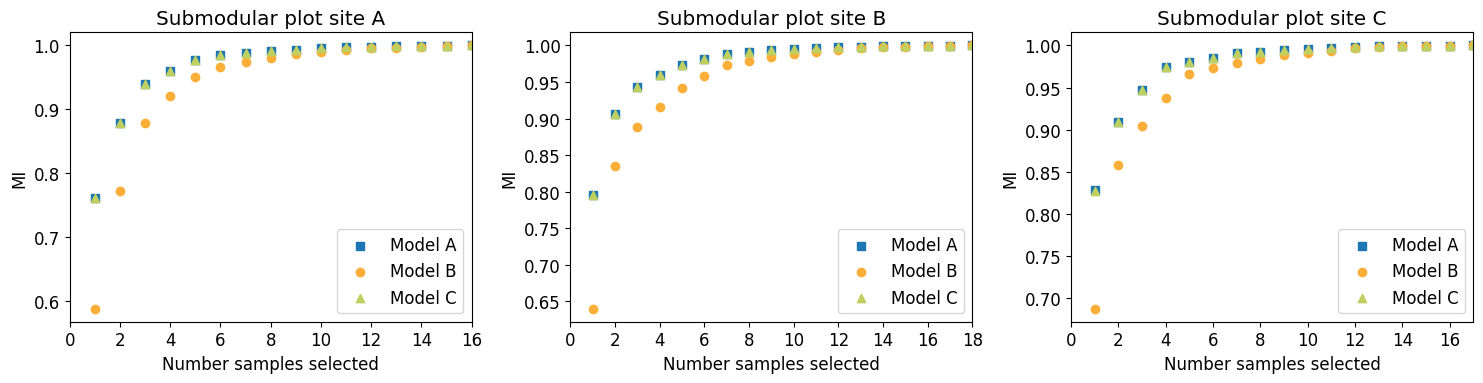

In [98]:
# Plotting the curves with subplots for each item in n_range
n_sites = len(site_ids)
n_cols = 4
n_rows = math.ceil(n_sites / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5* n_cols, 4 * n_rows))
axes = axes.flatten()

for idx, id in enumerate(alpha_site_id):
    if idx >= len(axes):
        break  # In case id_range has more than 9 items

    ax = axes[idx]
    for i, model_id in enumerate(alpha_site_id):
        dict_data = grabSamp_selection[id][model_id]
        samples = dict_data['samples']
        scores = dict_data['score']
        
        # Create a consistent x-axis since the samples is sample number, but we care about number of samples selected
        x_axis = range(1, len(samples) + 1)
        
        # Plot the curve, preserving the relationship between samples and scores
        ax.scatter(x_axis, scores, color=colr_sc[i], marker=markers[i], label=f'Model {model_id}')
    print(id, model_id, 'plotted')

    
    ax.set_xlabel('Number samples selected')
    ax.set_ylabel('MI')
    ax.set_title(f'Submodular plot site {id}')
    ax.legend()

    # Force x-axis to have integer ticks
    ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    ax.set_xlim(0, len(samples))

# Hide any unused subplots if alpha_site_id has less than 3 items
for i in range(len(alpha_site_id), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

# Error Plots
## Calculating for optimal selection
### Start at 2 samples to train and increase to 80% of available samples

In [99]:
# make array of sample order 
for idx, id in enumerate(alpha_site_id):
    if idx >= len(axes):
        break  # In case id_range has more than 9 items

    ax = axes[idx]
    for model_id in alpha_site_id:
        dict_data = grabSamp_selection[id][model_id]
        samples = dict_data['samples']
        scores = dict_data['score']

        print(samples)

[ 8  2 13  4 15 10  0  6 14  5  9  3  1  7 11 12]
[ 8  2 13  4 15 10  0  6 14  5  9  3  1  7 11 12]
[ 8  2 13  4 15 10  0  6 14  5  9  3  1  7 11 12]
[ 9  3 17 14  6  0 16 12  1  5  7 15 10  8 11  2 13  4]
[10  3 17  6 14  0 16 12  8  1  5  7 15 11  2  9 13  4]
[ 9  3 17 14  6  0 16 12  1  5  7 15 10  8 11  2 13  4]
[ 8  3 16 14  6 11  1  7 12 15  0 13  9  4 10  2  5]
[ 6 13 16  1  9 15 11  7  4  0 12  8 14  3 10  2  5]
[ 8  3 16 14  6 11  1  7 12 15  0 13  9  4 10  2  5]


In [112]:
optimal_dictionary = {}
sample_limit_fraction = 0.8

for i, site_id in enumerate(alpha_site_id):
    # site_data = data_dictionary[site_id]
    # all model data
    baseline_data = model_dictionary[site_id]['baseline']
    # all avaialbe training samples to select from
    all_x = baseline_data['x_train']
    all_y = baseline_data['y_train']
    # What to test models on
    test_x = baseline_data['x_test']
    test_y = baseline_data['y_test']

    globalX = np.concatenate([all_x, test_x])
    globalY = np.concatenate([all_y, test_y])
    global_min_x = globalX.min()
    global_max_x = globalX.max()
    global_min_y = globalY.min()
    global_max_y = globalY.max()
          
    num_train = len(all_x)

    baseline_rmse = baseline_data['scores']['rmse']
    baseline_r2 = baseline_data['scores']['r_score']
    # Hyperparameters 
    hp = baseline_data['hyperparams']
    print(hp)
    baesline_const = hp.get('k1__constant_value', None)
    baseline_l = hp.get('k2__length_scale', None)

    # sort data
    ord = np.argsort(all_x)
    all_x_sort = all_x[ord] 
    all_y_sort = all_y[ord]


    optimal_dictionary[site_id] = { 'baseline_hyperparams': {
                                        'length_scale' : baseline_l,
                                        'constant_value' : baesline_const,
                                    },
                                    'x_sort' : all_x_sort,
                                    'y_sort' : all_y_sort,
                                    'x_test' : test_x,
                                    'y_test' : test_y,
                                    'global_x': globalX,
                                    'global_y': globalY,
                                    'baseline_rmse' : baseline_rmse,
                                    'baseline_r_score' : baseline_r2,
                                    'num_train': num_train + len(test_x),
                                    'sample_limit': num_train,
    }

    for model_id in alpha_site_id:
        opt_select = grabSamp_selection[site_id][model_id]
        opt_indices = opt_select['samples']

        print(f'length of samples: {len(opt_indices)}')
        # initialize optimal_dicitionary 
        optimal_dictionary[site_id][model_id] = {}


        # leave 20% of samples for testing
        for n in np.arange(2,num_train):
            selected_idx = opt_indices[:n]
            opt_x = all_x_sort[selected_idx]
            opt_y = all_y_sort[selected_idx]

            # print(f'length of optx: {len(opt_x)}; n: {n}, length of test: {len(test_x)}')

            # train model using only optimal samples
            SAC_pred_opt, SSC_pred_opt, std_opt, GP_score_opt, GP_logmarg_opt, GP_model, n_alpha, x_scale, y_scale  = GP(opt_x, opt_y, p) 
            SAC_pred_opt, SSC_pred_opt, std_opt, GP_score_opt, GP_logmarg_opt, GP_model, n_alpha, x_scale, y_scale = GP(
                opt_x, opt_y, p,
                SAC_test=test_x, SSC_test=test_y,
                global_min_X=global_min_x, global_max_X=global_max_x,
                global_min_Y=global_min_y, global_max_Y=global_max_y,
            )
            kernel_params = extract_kernel_hyperparams(GP_model.kernel_)
            x_min, x_range = x_scale
            x_scaled = (test_x - x_min) / x_range
             # important ypred and ydata are sorted same order wrt xdata
            ypred_scaled, std_pred_scaled = GP_model.predict(x_scaled.reshape(-1, 1), return_std=True)  

            y_min, y_range = y_scale
            ypred = ypred_scaled * y_range + y_min
            std_pred = std_pred_scaled * y_range   

            MSE_opt = np.square(np.subtract(test_y,ypred)).mean() 
            rmse_opt = math.sqrt(MSE_opt)

            r_score_opt = GP_model.score(ypred.reshape(-1, 1),test_y.reshape(-1, 1))

            optimal_dictionary[site_id][model_id][n] = {    'hyperparams': kernel_params,
                                                            'x_train' : opt_x,
                                                            'y_train' : opt_y,
                                                            'n_pred' : ypred,
                                                            'p_pred' : [SAC_pred_opt, SSC_pred_opt, std_opt],
                                                            'scores': {
                                                                'GP_score':GP_score_opt, 
                                                                'GP_logmarg':GP_logmarg_opt,
                                                                'r_score': r_score_opt, 
                                                                'rmse' : rmse_opt, 
                                                                'std': std_pred,
                                                            },
                                                            'model' : GP_model,
                                                        }

{'k1__constant_value': 0.24558110891167173, 'k2__length_scale': 0.9295008620844819}
length of samples: 16


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 0.8. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/metrics/_regre

length of samples: 16


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 0.8. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/metrics/_regre

length of samples: 16


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 0.8. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/metrics/_regre

{'k1__constant_value': 0.5627717988526798, 'k2__length_scale': 0.6367929298437873}
length of samples: 18


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  

length of samples: 18


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 2.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  war

length of samples: 18


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__co

{'k1__constant_value': 0.3196340450749444, 'k2__length_scale': 0.929255012658807}
length of samples: 17


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 0.8. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/metrics/_regre

length of samples: 17


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.3. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/metrics/_regress

length of samples: 17


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.3. Decreasing the bound and calling fit again ma

Site A, Model A plotted
Site A, Model B plotted
Site A, Model C plotted
Site B, Model A plotted
Site B, Model B plotted
Site B, Model C plotted
Site C, Model A plotted
Site C, Model B plotted
Site C, Model C plotted

Baseline Model Summary:
Site                                                                                                                                                                                                                                                                                                                                                         Train Samples                                                                     Test Samples  Baseline RMSE  Baseline R²
   A                                             [1.3212794572498572, 1.3139471591817466, 0.545847463627567, 0.7113463302701236, 1.2204049487597295, 0.6972275674915892, 0.5235076907037766, 1.5905535153953307, 1.3759844440507, 1.033341669861324, 0.7404588611348147, 1.0814669549837572, 1.

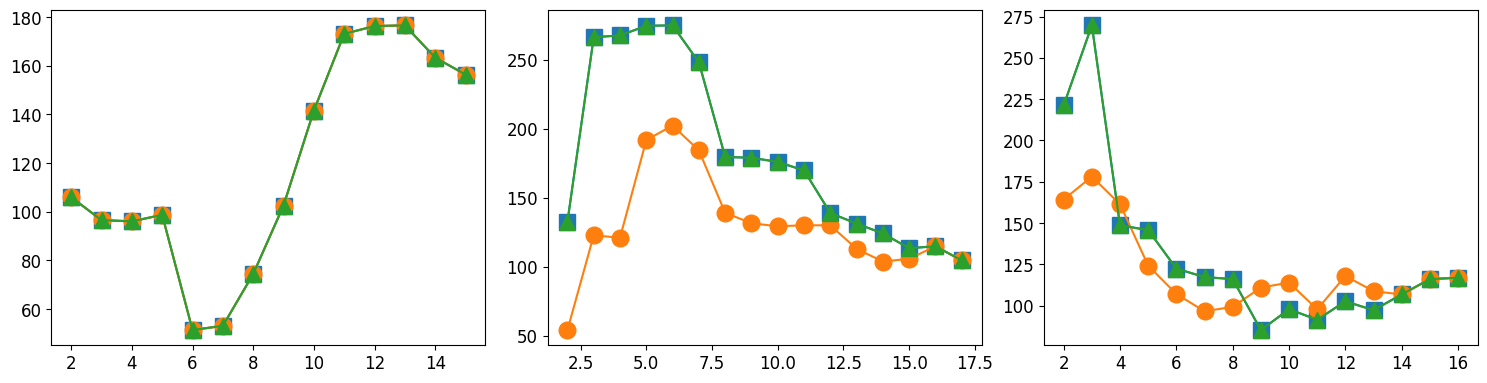

In [113]:
# Plotting the curves with subplots for each site in optimal_dictionary and random_dictionary
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5* n_cols, 4 * n_rows))
axes = axes.flatten()


for idx, site_id in enumerate(optimal_dictionary.keys()):
    if idx >= len(axes):
        break  # In case there are more than 3 sites

    ax = axes[idx]
    
    for i, model_id in enumerate(alpha_site_id):
        if model_id not in optimal_dictionary[site_id]:
            continue
        
        rmses = []
        sample_counts = []
        
        for n in sorted(optimal_dictionary[site_id][model_id].keys()):
            rmse = optimal_dictionary[site_id][model_id][n]['scores']['rmse']
            rmses.append(rmse)
            sample_counts.append(n)
        
        # Plot the curve
        ax.plot(sample_counts, rmses, linestyle='-', label=f'OMP {model_id}', marker = markers[i], markersize = '12')
        print(f'Site {site_id}, Model {model_id} plotted')

    sample_size = len(optimal_dictionary[site_id]['x_sort'])
    base_rmse = optimal_dictionary[site_id]['baseline_rmse']
    # ax.plot(range(sample_size), np.ones(sample_size)*base_rmse, color = 'red', linewidth = 3, label='baseline RMSE')

# Hide any unused subplots if optimal_dictionary has less than 3 sites
for i in range(len(optimal_dictionary), len(axes)):
    fig.delaxes(axes[i])

baseline_summary = []

for site_id in optimal_dictionary.keys():
    try:
        baseline = model_dictionary[site_id]['baseline']
        x_train_len = (baseline['x_train'])
        x_test_len = (baseline['x_test'])
        rmse = baseline['scores']['rmse']
        r2 = baseline['scores']['r_score']
        baseline_summary.append({
            'Site': site_id,
            'Train Samples': x_train_len,
            'Test Samples': x_test_len,
            'Baseline RMSE': round(rmse, 2),
            'Baseline R²': round(r2, 2)
        })
    except KeyError:
        baseline_summary.append({
            'Site': site_id,
            'Train Samples': 'Missing',
            'Test Samples': 'Missing',
            'Baseline RMSE': 'N/A',
            'Baseline R²': 'N/A'
        })

# Convert to DataFrame and print as table
baseline_df = pd.DataFrame(baseline_summary)
print("\nBaseline Model Summary:")
print(baseline_df.to_string(index=False))

plt.tight_layout()
# plt.savefig('figures/RMSE_comparison.png', dpi=500)
plt.show()



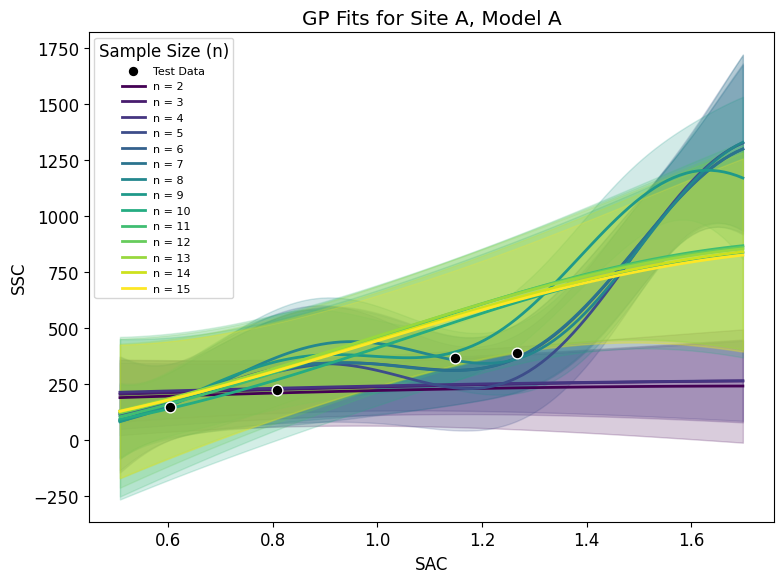

In [115]:
import matplotlib.pyplot as plt

site_id = 'A'
model_id = 'A'

fig, ax = plt.subplots(figsize=(8, 6))

# Get the global test data from the site's baseline model
baseline = model_dictionary[site_id]['baseline']
test_x = baseline['x_test']
test_y = baseline['y_test']

# Plot test data
ax.scatter(test_x, test_y, color='black', edgecolors='white', s=60, label='Test Data', zorder=5)


# Colormap for distinction
colors = plt.cm.viridis(np.linspace(0, 1, len(optimal_dictionary[site_id][model_id])))

for idx, n in enumerate(sorted(optimal_dictionary[site_id][model_id].keys())):
    fold = optimal_dictionary[site_id][model_id][n]
    SAC_pred, SSC_pred, std_pred = fold['p_pred']

    label = f"n = {n}"
    ax.plot(SAC_pred, SSC_pred, color=colors[idx], label=label, linewidth=2)
    ax.fill_between(
        SAC_pred,
        SSC_pred - 1.96 * std_pred,
        SSC_pred + 1.96 * std_pred,
        color=colors[idx],
        alpha=0.2
    )

ax.set_title(f"GP Fits for Site {site_id}, Model {model_id}")
ax.set_xlabel("SAC")
ax.set_ylabel("SSC")
ax.legend(title="Sample Size (n)", fontsize=8)
plt.tight_layout()
plt.show()


Site A, Model A plotted
Site A, Model B plotted
Site A, Model C plotted
Site B, Model A plotted
Site B, Model B plotted
Site B, Model C plotted
Site C, Model A plotted
Site C, Model B plotted
Site C, Model C plotted


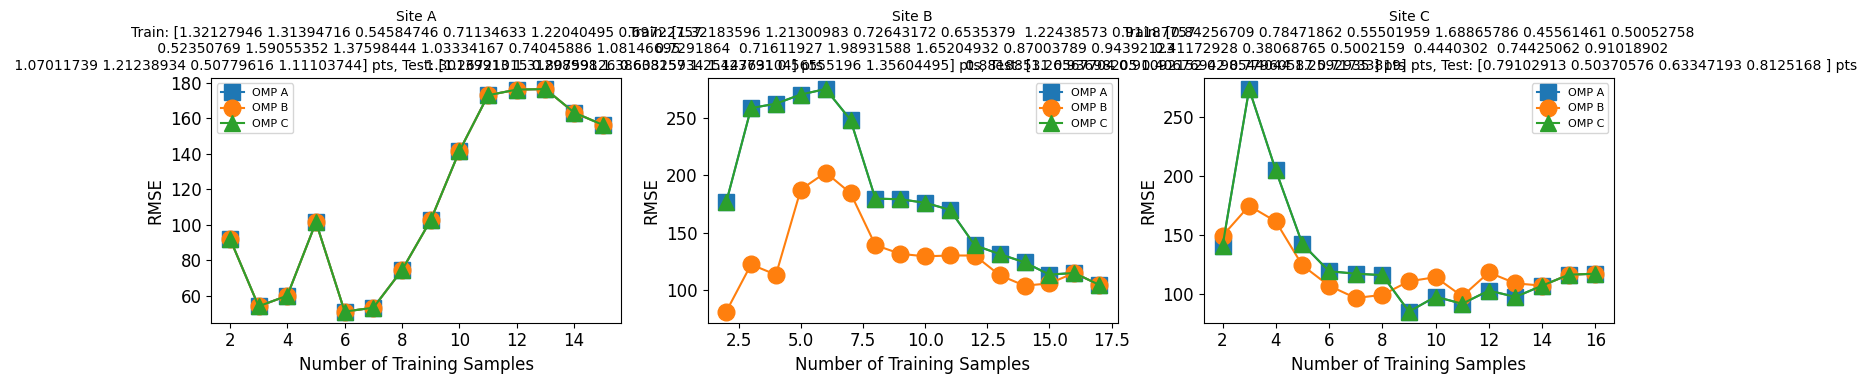

## Random calculation

In [23]:
# r is number of runs to do, n is number of samples to make model off of, id is site id to use
# don't need to pass in data since always the same

def random_samp_models(r, n, xdata, ydata):
    seed_num = 0
    seed_lock = True

    # site_data = data_dictionary[id]
    # xdata = site_data['Samples']['SAC'].to_numpy()
    # ydata = site_data['Samples']['SSC'].to_numpy()


    if seed_lock == True:
        random.seed(seed_num)

    #initial arrays to store all runs
    SAC_r, SSC_r, ind_r, date_time_r, \
    SAC_pred, SSC_pred, std, GP_score, GP_logmarg, GP_model, n_alpha, x_scale, y_scale = ([None] * r for i in range(13))

    i=0 #create subset of data for all subsets i
    while i < r:
        L = np.linspace(0,len(xdata)-1,len(xdata)).astype(int)
        ind = random.sample(list(L), n)
        
        #Store run i random subset
        SAC_r[i] = xdata[ind]
        SSC_r[i] = ydata[ind]
        ind_r[i] = ind
        # print(xdata[ind])

        SAC_pred[i], SSC_pred[i], std[i], GP_score[i], GP_logmarg[i], GP_model[i], n_alpha[i], x_scale[i], y_scale[i] = GP(SAC_r[i], SSC_r[i], p)
        i += 1

    return (SAC_r, SSC_r, ind_r, SAC_pred, SSC_pred, std, GP_score, GP_logmarg, GP_model, n_alpha, x_scale, y_scale)

In [27]:
import numpy as np

def proportional_stratified_sample(xdata, n_samples, n_bins=5):
    bins = np.linspace(np.min(xdata), np.max(xdata), n_bins + 1)
    indices = []
    
    counts = []
    bin_indices_list = []
    for i in range(n_bins):
        if i < n_bins - 1:
            bin_mask = (xdata >= bins[i]) & (xdata < bins[i+1])
        else:
            bin_mask = (xdata >= bins[i]) & (xdata <= bins[i+1])  # include max in last bin
        bin_indices = np.where(bin_mask)[0]
        bin_indices_list.append(bin_indices)
        counts.append(len(bin_indices))
    
    total_count = sum(counts)
    samples_per_bin = [int(round(n_samples * c / total_count)) for c in counts]
    
    for i in range(n_bins):
        if len(bin_indices_list[i]) <= samples_per_bin[i]:
            indices.extend(bin_indices_list[i])
            samples_per_bin[i] = 0
        else:
            chosen = np.random.choice(bin_indices_list[i], samples_per_bin[i], replace=False)
            indices.extend(chosen)
            samples_per_bin[i] = 0
    
    leftover = n_samples - len(indices)
    if leftover > 0:
        remaining_indices = list(set(range(len(xdata))) - set(indices))
        if len(remaining_indices) >= leftover:
            indices.extend(np.random.choice(remaining_indices, leftover, replace=False))
        else:
            indices.extend(remaining_indices)
    
    return np.array(indices)


In [ ]:
'''i = 0
while i < r:
    ind = proportional_stratified_sample(xdata, n, n_bins=5)

    # Optional: check if range is sufficient to avoid normalization error
    if np.ptp(xdata[ind]) < 1e-8:
        print(f"Sample {i} has too small x range, resampling...")
        continue

    SAC_r[i] = xdata[ind]
    SSC_r[i] = ydata[ind]
    ind_r[i] = ind

    SAC_pred[i], SSC_pred[i], std[i], GP_score[i], GP_logmarg[i], GP_model[i], n_alpha[i], x_scale[i], y_scale[i] = GP(SAC_r[i], SSC_r[i], p)
    i += 1'''

    # r is number of runs to do, n is number of samples to make model off of, id is site id to use
# don't need to pass in data since always the same

def random_samp_models(r, n, xdata, ydata):
    seed_num = 0
    seed_lock = True

    # site_data = data_dictionary[id]
    # xdata = site_data['Samples']['SAC'].to_numpy()
    # ydata = site_data['Samples']['SSC'].to_numpy()


    if seed_lock == True:
        random.seed(seed_num)

    #initial arrays to store all runs
    SAC_r, SSC_r, ind_r, date_time_r, \
    SAC_pred, SSC_pred, std, GP_score, GP_logmarg, GP_model, n_alpha, x_scale, y_scale = ([None] * r for i in range(13))

    i=0 #create subset of data for all subsets i
    while i < r:
        # L = np.linspace(0,len(xdata)-1,len(xdata)).astype(int)
        # ind = random.sample(list(L), n)

        ind = proportional_stratified_sample(xdata, n, n_bins=5)
        # Check if range in x and y is sufficient
        if np.ptp(xdata[ind]) < 1e-8 or np.ptp(ydata[ind]) < 1e-8:
            print(f"Resampling due to low x/y range in iteration {i}")
            continue
        
        #Store run i random subset
        SAC_r[i] = xdata[ind]
        SSC_r[i] = ydata[ind]
        ind_r[i] = ind
        # print(xdata[ind])

        SAC_pred[i], SSC_pred[i], std[i], GP_score[i], GP_logmarg[i], GP_model[i], n_alpha[i], x_scale[i], y_scale[i] = GP(SAC_r[i], SSC_r[i], p)
        i += 1

    return (SAC_r, SSC_r, ind_r, SAC_pred, SSC_pred, std, GP_score, GP_logmarg, GP_model, n_alpha, x_scale, y_scale)


In [ ]:
# now we're going to make a dictionary of the different trials with different number of points
r = 20
#generalize for all sites
# sample_size = np.arange(1,21)
# sample_size = [5,10,8]
# id = 1

random_dictionary = {}

import warnings
from sklearn.exceptions import UndefinedMetricWarning, ConvergenceWarning

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    warnings.filterwarnings("ignore", category=UserWarning, message="One or more of the test scores are non-finite")


    for i, site_id in enumerate(alpha_site_id):
        random_dictionary[site_id] = {}
        print(f'site_id: {site_id}')
        
        all_data = model_dictionary[site_id]
        all_x = all_data['x']
        all_y = all_data['y']
        num_total = len(all_x)
        sample_limit = int(np.ceil(num_total * sample_limit_fraction))

        baseline_rmse = all_data['scores']['rmse']
        hp = all_data['hyperparams']
        baesline_const = hp.get('k1__constant_value', None)
        baseline_l = hp.get('k2__length_scale', None)

        # sort data
        ord = np.argsort(all_x)
        all_x_sort = all_x[ord] 
        all_y_sort = all_y[ord]

        #scale data


        random_dictionary[site_id] = {  'baseline_hyperparams': {
                                            'length_scale' : baseline_l,
                                            'constant_value' : baesline_const,
                                        },
                                        'x_all' : all_x_sort,
                                        'y_all' : all_y_sort,
                                        'baseline_rmse' : baseline_rmse,
                                        'num_samples' : len(all_x_sort),
                                        'num_total': num_total,
                                        'sample_limit': sample_limit,
                                    }
        
        num_samp = random_dictionary[site_id]['num_samples']
        # start with using 2 samples
        sample_size = np.arange(2,sample_limit)

        print(f"Site {site_id}, n = {sample_limit} ")
        
        for n in sample_size:
            SAC_r, SSC_r, ind_r, SAC_pred_r, SSC_pred_r, std_r, GP_score_r, GP_logmarg_r, GP_model_r, n_alpha_r, x_scale_r, y_scale_r = random_samp_models(r, n, all_x, all_y)
            print(n)
            #initalize list to hold all ypred for given number of samples 
            ypred_r = ([None] * r) 
            const_rand = ([None] * r) 
            l_rand = ([None] * r) 
            std_pred_r = ([None] * r) 
            rmse_r = ([None] * r)

            # make prediction for all data points using model and calculate rmse
            for i in range(r):
                x_train = all_x[ind_r[i]]
                y_train = all_y[ind_r[i]]
                x_test =  np.delete(all_x,ind_r[i]) 
                x_min, x_range = x_scale
                x_scaled = (x_test - x_min) / x_range
                # print(x_test)
                y_test = np.delete(all_y,ind_r[i]) 
                ypred_scaled, std_pred_scaled = GP_model_r[i].predict(x_scaled.reshape(-1, 1), return_std=True, return_cov=False)
                
                y_min, y_range = y_scale
                ypred_r[i] = ypred_scaled * y_range + y_min
                std_pred_r = std_pred_scaled * y_range   
                
                MSE_r = np.square(np.subtract(y_test,ypred_r[i])).mean()     
                rmse_r[i] = math.sqrt(MSE_r) 
                kernel_params = extract_kernel_hyperparams(GP_model_r[i].kernel_)
                const_rand[i] = kernel_params.get('k1__constant_value', None)
                l_rand[i] = kernel_params.get('k2__length_scale', None)
                

            rmse_r = np.asarray(rmse_r)


            random_dictionary[site_id][n] = {   'hyperparams': {
                                                    'rbf_l' : l_rand,
                                                    'noise_l' : const_rand,
                                                },
                                                'xdata' : SAC_r,
                                                'ydata' : SSC_r,
                                                'indicies' : ind_r,
                                                'n_pred' : ypred_r,
                                                'p_pred' : [SAC_pred_r, SSC_pred_r, std_r],
                                                'score' : {
                                                    'GP_score' : GP_score_r,
                                                    'GP_logmarg' : GP_logmarg_r,
                                                    'rmse' : rmse_r, 
                                                    'std': std_pred_r,
                                                },
                                                'model' : GP_model_r,
                                                'rmse_mean' : rmse_r.mean(),
                                                'rmse_std' : rmse_r.std(),
                                                'rmse_best' : [rmse_r.min(), rmse_r.argmin()],
                                                'rmse_worst' : [rmse_r.max(), rmse_r.argmax()]
                                            }



site_id: A


KeyError: 'x'

## Plot error bars

[214.74600878313547, 264.9502693944858, 217.4141524381199, 237.23946584162678, 167.71181880778252, 163.42787235174217, 162.1456162979579, 166.17236292355264, 197.30705749801766, 202.00607776873045, 221.22540614787903, 202.61860151395678, 233.9463297556344, 81.01264237597321]
[308.8508716428758, 305.7070880727686, 201.09237405076584, 195.08517688788038, 159.50164254360502, 131.9966328543797, 179.469501510071, 113.63559088398935, 182.0948278285949, 194.14923605538874, 128.146263102285, 123.49174616834657, 165.627039815735, 127.07467541471615, 164.08554957223018, 132.29539378513132]
[195.6893975706931, 117.86389336846624, 108.00367355194213, 126.10954193608048, 128.16745317487974, 116.39782606515682, 132.1629433946345, 122.51090048742577, 144.1336978523208, 77.06063436741054, 64.67047707192832, 60.603069632581835, 74.5601183247722, 70.41813695293779, 59.67967871754601]


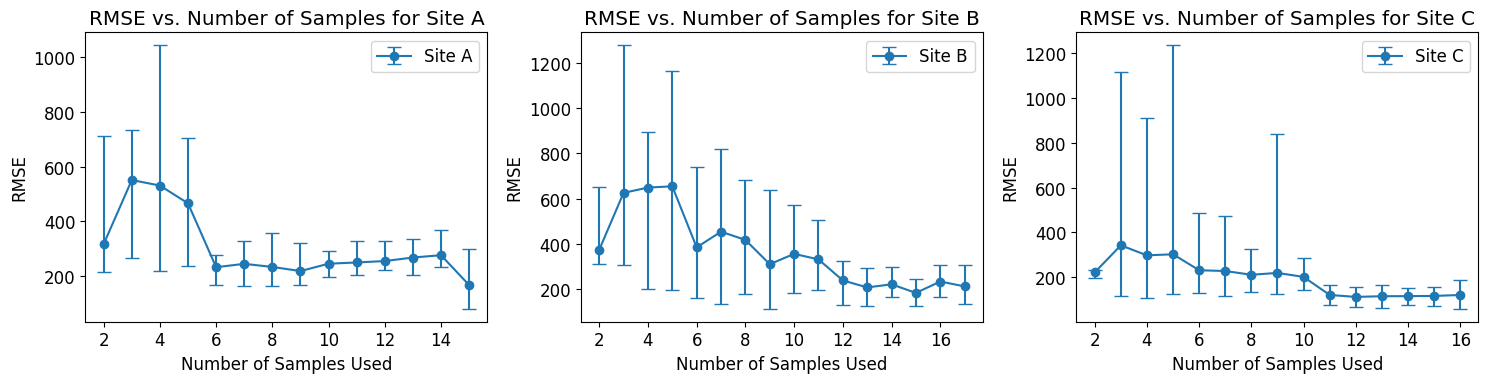

In [36]:
# Plotting the curves with subplots for each site in random_dictionary
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5* n_cols, 4 * n_rows))
axes = axes.flatten()

for idx, site_id in enumerate(random_dictionary.keys()):
    if idx >= len(axes):
        break  # In case there are more than 3 sites

    ax = axes[idx]
    
    sample_sizes = []
    rmse_means = []
    rmse_mins = []
    rmse_maxs = []

    for n in random_dictionary[site_id].keys():
        
        if isinstance(n, np.int64):
            # print(n)
            sample_sizes.append(n)
            rmse_means.append(random_dictionary[site_id][n]['rmse_mean'])
            rmse_mins.append(random_dictionary[site_id][n]['rmse_best'][0])
            rmse_maxs.append(random_dictionary[site_id][n]['rmse_worst'][0])

    # Plot the curve with error bars
    print(rmse_mins)
    ax.errorbar(sample_sizes, rmse_means, yerr=[np.array(rmse_means) - np.array(rmse_mins), np.array(rmse_maxs) - np.array(rmse_means)],
                fmt='-o', capsize=5, label=f'Site {site_id}')
    
    ax.set_xlabel('Number of Samples Used')
    ax.set_ylabel('RMSE')
    ax.set_title(f'RMSE vs. Number of Samples for Site {site_id}')
    ax.legend()

    # Force x-axis to have integer ticks
    ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

# Hide any unused subplots if random_dictionary has less than 3 sites
for i in range(len(random_dictionary), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
# plt.show()



## Plot optimal and random error plots together

Site A, Model A plotted
Site A, Model B plotted
Site A, Model C plotted
Site B, Model A plotted
Site B, Model B plotted
Site B, Model C plotted
Site C, Model A plotted
Site C, Model B plotted
Site C, Model C plotted


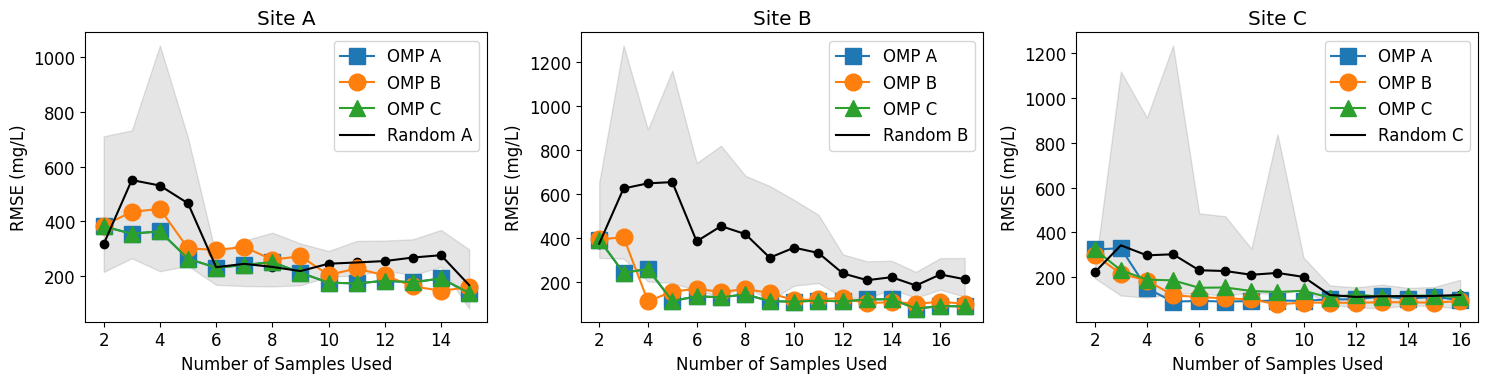

In [37]:
# Plotting the curves with subplots for each site in optimal_dictionary and random_dictionary
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5* n_cols, 4 * n_rows))
axes = axes.flatten()

for idx, site_id in enumerate(optimal_dictionary.keys()):
    if idx >= len(axes):
        break  # In case there are more than 3 sites

    ax = axes[idx]
    
    for i, model_id in enumerate(alpha_site_id):
        if model_id not in optimal_dictionary[site_id]:
            continue
        
        rmses = []
        sample_counts = []
        
        for n in sorted(optimal_dictionary[site_id][model_id].keys()):
            rmse = optimal_dictionary[site_id][model_id][n]['scores']['rmse']
            rmses.append(rmse)
            sample_counts.append(n)
        
        # Plot the curve
        ax.plot(sample_counts, rmses, linestyle='-', label=f'OMP {model_id}', marker = markers[i], markersize = '12')
        print(f'Site {site_id}, Model {model_id} plotted')

    sample_size = len(optimal_dictionary[site_id]['x_sort'])
    base_rmse = optimal_dictionary[site_id]['baseline_rmse']
    # ax.plot(range(sample_size), np.ones(sample_size)*base_rmse, color = 'red', linewidth = 3, label='baseline RMSE')

for idx, site_id in enumerate(random_dictionary.keys()):
    if idx >= len(axes):
        break  # In case there are more than 3 sites

    ax = axes[idx]
    
    sample_sizes = []
    rmse_means = []
    rmse_mins = []
    rmse_maxs = []

    for n in random_dictionary[site_id].keys():
        
        if isinstance(n, np.int64):
            # print(n)
            sample_sizes.append(n)
            rmse_means.append(random_dictionary[site_id][n]['rmse_mean'])
            rmse_mins.append(random_dictionary[site_id][n]['rmse_best'][0])
            rmse_maxs.append(random_dictionary[site_id][n]['rmse_worst'][0])

    # Plot the curve with error bars
    # print(rmse_mins)
    # ax.errorbar(sample_sizes, rmse_means, yerr=[np.array(rmse_means) - np.array(rmse_mins), np.array(rmse_maxs) - np.array(rmse_means)],
                # fmt='-o', capsize=5, label=f'Random {site_id}', color = 'black')
    # Plot the shaded error bounds
    ax.plot(sample_sizes, rmse_means, color='black',label=f'Random {site_id}')
    ax.scatter(sample_sizes, rmse_means, color='black')
    ax.fill_between(sample_sizes, rmse_mins, rmse_maxs, color='black', alpha=0.1)
    
    ax.set_xlabel('Number of Samples Used')
    ax.set_ylabel('RMSE (mg/L)')
    ax.set_title(f'Site {site_id}')
    ax.legend()

    # Force x-axis to have integer ticks
    ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
# Hide any unused subplots if optimal_dictionary has less than 3 sites
for i in range(len(optimal_dictionary), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
# plt.savefig('figures/RMSE_comparison.png', dpi=500)
plt.show()



In [18]:
from scipy.spatial.distance import norm

# Just comparing the correlation matrices
A_mat = correlation_matrices['A']['num_samp']['A']['cor_matrix']
B_mat = correlation_matrices['A']['num_samp']['C']['cor_matrix']
n_samp = correlation_matrices['A']['num_samp']['A']['n']

print("Matrix difference (Frobenius norm):", norm(A_mat - B_mat)/math.sqrt(n_samp))


Matrix difference (Frobenius norm): 0.27564023425780465


In [19]:
print(model_dictionary['A']['hyperparams'])
print(model_dictionary['B']['hyperparams'])

{'k1__constant_value': 0.21854947117839632, 'k2__length_scale': 0.9299884422355191}
{'k1__constant_value': 0.4555117039193293, 'k2__length_scale': 0.5310235349921094}


In [20]:
diff_norm = np.linalg.norm(A_mat - B_mat, 'fro')
print("Raw difference norm:", diff_norm)
print("Normalized by sqrt(n_samp):", diff_norm / np.sqrt(n_samp))

Raw difference norm: 1.2327006022688352
Normalized by sqrt(n_samp): 0.27564023425780465


In [21]:
norm_A = np.linalg.norm(A_mat, 'fro')
print("Norm of A_mat:", norm_A)
print("Relative difference:", diff_norm / norm_A)


Norm of A_mat: 16.825278058264082
Relative difference: 0.0732647982398941
